epoch 0/30


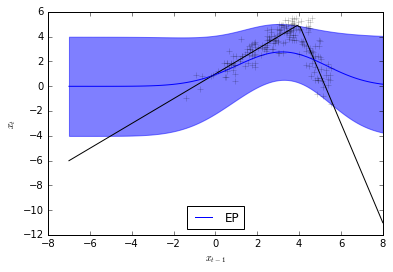

epoch 1/30
epoch 2/30
epoch 3/30
epoch 4/30
epoch 5/30


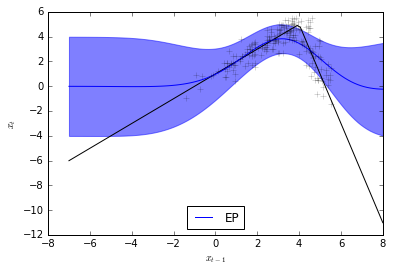

epoch 6/30
epoch 7/30
epoch 8/30
epoch 9/30
epoch 10/30


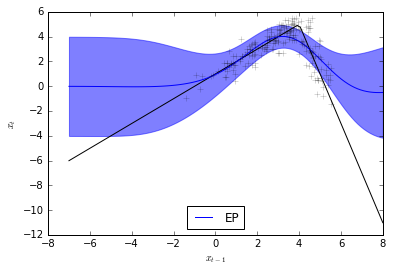

epoch 11/30
epoch 12/30
epoch 13/30
epoch 14/30
epoch 15/30


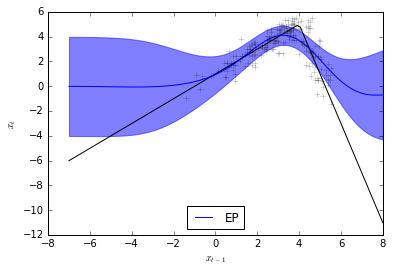

epoch 16/30
epoch 17/30
epoch 18/30
epoch 19/30
epoch 20/30


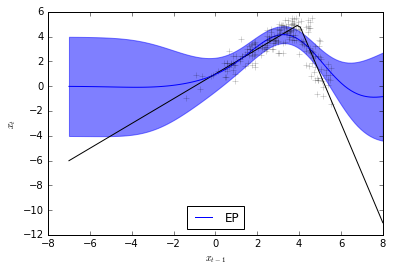

epoch 21/30
epoch 22/30
epoch 23/30
epoch 24/30
epoch 25/30


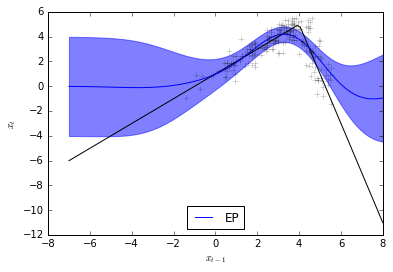

epoch 26/30
epoch 27/30
epoch 28/30
epoch 29/30


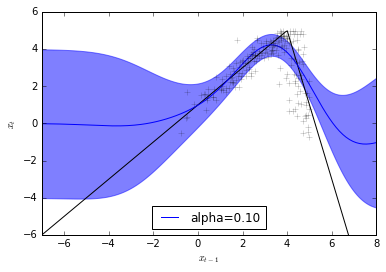

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import os, sys
sys.path.insert(0, "../")
import geepee.ep_models as ep
import pdb
%matplotlib inline

np.random.seed(42)

def test_kink():
    def kink_true(x):
        fx = np.zeros(x.shape)
        for t in range(x.shape[0]):
            xt = x[t]
            if xt < 4:
                fx[t] = xt + 1
            else:
                fx[t] = -4*xt + 21
        return fx

    def kink(T, process_noise, obs_noise, xprev=None):
        if xprev is None:
            xprev = np.random.randn()
        y = np.zeros([T, ])
        x = np.zeros([T, ])
        xtrue = np.zeros([T, ])
        for t in range(T):
            if xprev < 4:
                fx = xprev + 1
            else:
                fx = -4*xprev + 21

            xtrue[t] = fx
            x[t] = fx + np.sqrt(process_noise)*np.random.randn()
            xprev = x[t]
            y[t] = x[t] + np.sqrt(obs_noise)*np.random.randn()

        return xtrue, x, y

    T = 200
    process_noise = 0.2
    obs_noise = 0.1
    (xtrue, x, y) = kink(T, process_noise, obs_noise)
    y_train = np.reshape(y, [y.shape[0], 1])
    # pdb.set_trace()

    alpha = 0.1
    Dlatent = 1
    Dobs = 1
    M = 40
    C = 1*np.ones((1, 1))
    R = np.ones(1)*np.log(obs_noise)/2
    lls = np.reshape(np.log(2), [Dlatent, ])
    lsf = np.reshape(np.log(2), [1, ])
    zu = np.linspace(-7, 7, M)
    zu = np.reshape(zu, [M, 1])
    lsn = np.log(process_noise)/2
    params = {'ls': lls, 'sf': lsf, 'sn': lsn, 'R': R, 'C': C, 'zu': zu}

    # create model
    model = ep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1)
    # update hypers
    model.update_hypers(params)
    # run EP
    model.inference(no_epochs=30, alpha=alpha, parallel=True, decay=0.99)

    # make prediction on some test inputs
    N_test = 200
    x_test = np.linspace(-7, 8, N_test)
    x_test = np.reshape(x_test, [N_test, 1])
    mf, vf = model.predict_f(x_test)

    # plot function
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test[:,0], kink_true(x_test[:,0]), '-', color='k')
    ax.plot(x_test[:,0], mf[:,0], 
            '-', color='b', label='alpha=%.2f'%alpha)
    ax.fill_between(
        x_test[:,0], 
        mf[:,0] + 2*np.sqrt(vf[:,0]), 
        mf[:,0] - 2*np.sqrt(vf[:,0]), 
        alpha=0.5, edgecolor='b', facecolor='b')
    ax.plot(
        xtrue[0:model.N-1], 
        xtrue[1:model.N], 
        'k+', alpha=0.3)
    ax.set_xlabel(r'$x_{t-1}$')
    ax.set_ylabel(r'$x_{t}$')
    ax.set_ylim(-6, 6)
    ax.set_xlim(-7, 8)
    ax.legend(loc='lower center')

    plt.show()

test_kink()